# Deepwalk performance debugging: absolute minimal hetionet

We created a completely fake network with randomly generated edges to test our framework. We also prevented the gold standard edges from being included into the network. This will hopefully give us a lower ROC score that we expect.

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from itertools import chain

from glob import glob
import os
import seaborn as sns

In [2]:
%matplotlib inline

---

if no embedding for training data


In [3]:
def add_features(df, features, mergetype):
    return (df
        .merge(
            features, how=mergetype, left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how=mergetype, left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize, mergetype):
    reg = add_features(df, features, mergetype)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

there are nodes in the holdout dataset that did not have any embeddings generated for it. check to see if they had proper adjlists made

In [4]:
def eval_performance(fbase, K, vecsize):
    for idx in range(K):
        train = pd.read_csv(
            "tmp/data/train/{}_train_{}.tsv".format(fbase, idx),
            sep='\t'
        )
        
        holdout = pd.read_csv(
            "tmp/data/holdout/{}_holdout_{}.tsv".format(fbase, idx),
            sep='\t'
        )

        features = pd.read_csv(
            "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, idx),
            sep=" ", skiprows=1,
            names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
        )
        

        tmp = convolv_features(train, features, vecsize, "inner")
        
        print(tmp.shape)
#         print(tmp["etype"].value_counts())

        feat_cols = ["conv{}".format(j) for j in range(vecsize)]
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

        # test on holdout
        test = convolv_features(
            holdout.drop("etype", axis=1),
            features, vecsize, "left"
        )
        
        assert len(test) == len(holdout)
        
        # if there are empty ones in the features column,
        # then we didn't generate any embeddings, and therefore
        # need to split those up and treat as zeroes
        # for the others we can predict normally, then join together
        
        regular = test[test["conv0"].notnull()].assign(missed = False)
        
        missed = (test[test["conv0"].isnull()]
            .assign(
                predval = 0
            )
            .assign(missed = True)
        )
  
        print(regular.shape)
        print(missed.shape)
                
        # add in predictions
        ans = regular.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        ans = ans.append(missed)
        
        assert len(ans) == len(holdout)
        
        yield (ans
            [["chemical_uid", "disease_uid", "predval", "missed"]]
            .merge(
                holdout[["chemical_uid", "disease_uid", "etype"]],
                how="inner", on=["chemical_uid", "disease_uid"]
            )
            .sort_values("predval", ascending=False)
            .reset_index(drop=True)
        )

In [5]:
def finished(fbase, K):
    for i in range(K):
        ename = "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, i)
        
        if not os.path.isfile(ename):
            return False

    return True

need to check that we have the expected embeddings for the concepts

In [16]:
vecsize = 16

stuff = []

missed = []
for edge_fname in tqdm(glob("tmp/edges/fake*.tsv")):
    fbase = edge_fname.split("/")[2][:-4]
    
    K = 4
    
    # check if all K embeddings are done
    if finished(fbase, K):
        aucs = []
        for res in eval_performance(fbase, K, vecsize):
            
            stuff.append(res)
            
#             precision, recall, thresh = precision_recall_curve(res["etype"], res["predval"])
#             auc_val = auc(recall, precision)
            
            fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])
            auc_val = auc(fpr, tpr)

            aucs.append(auc_val)
            
            missed.append((res["missed"].sum(), len(res), len(res.query("missed and etype == 1"))))

        temp = (pd
            .Series(aucs)
            .to_frame("auc_roc")
            .assign(edge_val = fbase)
        )
        
        temp.to_csv(
            "tmp/results/{}.tsv".format(fbase), sep='\t', index=False
        )

  0%|          | 0/1 [00:00<?, ?it/s]

(9548, 21)
(78002, 21)
(16012, 22)
(9540, 21)
(74153, 21)
(18475, 22)
(9331, 21)
(78288, 21)
(13793, 22)
(9604, 21)
(69174, 21)
(15786, 22)


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


---

In [7]:
mdata = pd.DataFrame(missed, columns=["num_missed", "total", "missed_and_true"])

In [8]:
mdata.shape

(4, 3)

In [9]:
mdata

,num_missed,total,missed_and_true
0,16012,94014,83
1,18475,92628,79
2,13793,92081,65
3,15786,84960,91


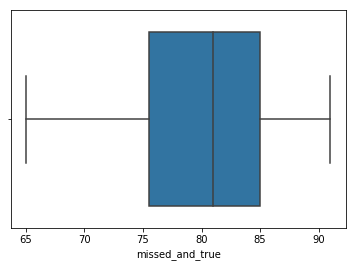

In [10]:
sns.boxplot(mdata["missed_and_true"])

seems to have been no difference in performance between the version where some of the gold standard is in the network vs gold standard relations are removed from the network

---

In [17]:
res = [
    pd.read_csv(fname, sep='\t')
    for fname in glob("tmp/results/fake*.tsv")
]

res = pd.concat(res)

In [18]:
res.shape

(4, 2)

In [19]:
res # 16 features

,auc_roc,edge_val
0,0.533702,fake_network
1,0.582136,fake_network
2,0.551383,fake_network
3,0.543494,fake_network


In [15]:
res # 128 features

,auc_roc,edge_val
0,0.617928,fake_network
1,0.630181,fake_network
2,0.597326,fake_network
3,0.606832,fake_network


In [14]:
res["auc_roc"].mean()

0.61306675508910258

averaged over 4 runs, we are still getting higher roc values for our complete random network when there are too many features. too many features allows us to overfit even on random noise

In [28]:
res # 128 features

,auc_roc,edge_val
0,0.611504,fake_network


moving up to 128 features when we only have a total of 500 trues in the holdout seems to be able to skew our roc scores to something that isn't as close to 0.5. this may be a property of the random walk, which we will need to redo to see if it's true

conclusion is: we need to not be including the gold standard edges directly in the network

we need to make sure we can generate embeddings for at least some of the chemical-disease pairs which show up in the training data (otherwise our regression fails with no data)

In [19]:
res # 16 features

,auc_roc,edge_val
0,0.547325,fake_network


roc results with 16 features and the normal (more negatives than positives) gold standard gives 0.54 roc which is much closer than we expect. this is looking good. the real problem seems to be the fact that we are including the gold standard edges in the network, which is throwing off the results. so we need to make sure that the side effects are somehow included without linking them to the compounds directly?